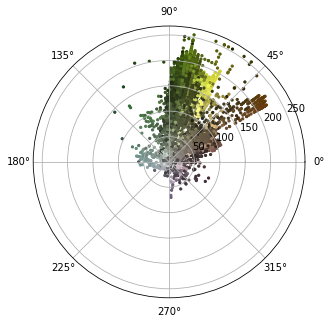

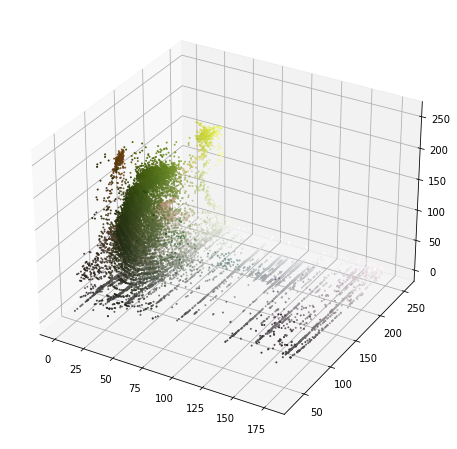

In [127]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import math

def show_img(path):

    img = cv2.imread(path)
    img.resize(300,200,3)

    rgbimg = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    hsvimg = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h, s, v = hsvimg[:,:,0], hsvimg[:,:,1], hsvimg[:,:,2]



    fig = plt.figure(figsize=(5, 5))
    ax=plt.subplot(111,projection="polar")
 
    
    
    """
    ax.set_thetagrids(np.arange(0.0, 360.0, 15.0))
    ax.set_thetamin(0.0)  # 设置极坐标图开始角度为0°
    ax.set_thetamax(360.0)  # 设置极坐标结束角度为180°
    ax.set_rgrids(np.arange(0, 255.0, 100.0))
    ax.set_rlabel_position(0.0)  # 标签显示在0°
    ax.set_rlim(0.0, 360.0)  # 标签范围为[0, 5000)
    
    ax.grid(True, linestyle="-", color="k", linewidth=0.5, alpha=0.5)"
    """    
    #ax.set_axisbelow('True')  # 使散点覆盖在坐标系之上

    h2=np.asarray(h,dtype="float")
    plt.scatter(h2.flatten()*2*math.pi/178.0, s.flatten(), s=5.0,c=rgbimg.reshape(-1,3)/255.0)
    plt.show()

    fig = plt.figure(figsize=(8, 8))
    ax = plt.axes(projection='3d')
    ax.scatter3D(h, v, s, c=rgbimg.reshape(-1,3)/255.0,s=1)
    #return hist_r,hist_g, hist_b, hist_h, hist_s, hist_v

show_img(r"E:\Downloads\BaiduNetdiskDownload\testfile\2L7A2079.JPG")
#show_img(r"E:\Downloads\BaiduNetdiskDownload\output\2L7A1998_kmeans.png")
